In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Activation, Flatten, ConvLSTM2D, Conv1D, MaxPooling1D, RepeatVector, TimeDistributed, Conv2D, ConvLSTM2D, MaxPool2D, RepeatVector
import keras
import tensorflow
import seaborn as sns
from sklearn.metrics import mean_squared_error


In [2]:
from google.colab import files
uploaded = files.upload()

Saving NIFTY50 - NIFTY50.csv to NIFTY50 - NIFTY50.csv


In [3]:
import io
Data=pd.read_csv(io.BytesIO(uploaded['NIFTY50 - NIFTY50.csv']))

In [4]:
cols= list(Data)[1:5]
stock_prices = Data[cols].astype(float)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(stock_prices)
stock_prices_scaled = scaler.transform(stock_prices)
print('df_for_training_scaled shape == {}.'.format(stock_prices_scaled.shape))

df_for_training_scaled shape == (3326, 4).


In [6]:
train_size = int(len(stock_prices_scaled) * 0.66)
test_size = len(stock_prices_scaled) - train_size
train, test = stock_prices_scaled[0:train_size,:], stock_prices_scaled[train_size:len(stock_prices_scaled),:]


In [7]:
trainX = []
trainY=[]

In [8]:
n_future = 1   # Number of days we want to predict into the future
n_past = 14   # Number of past days we want to use to predict the future
for i in range(n_past, len(train) - n_future +1):
    trainX.append(train[i - n_past:i, 0:train.shape[1]])
    #train_opening_labels.append(train[i + n_future - 1:i + n_future, 0])
    trainY.append(train[i + n_future - 1:i + n_future, 1])
trainX, trainY = np.array(trainX), np.array(trainY)


In [26]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
#input_shape=( trainX.shape[1], trainX.shape[2])
#print(input_shape)

trainX shape == (2181, 14, 4).
trainY shape == (2181, 1).


In [13]:
trainX_re=trainX.reshape((trainX.shape[0],1,trainX.shape[1],trainX.shape[2]))
trainX_re.shape

(2181, 1, 14, 4)

In [15]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape = (None,trainX_re.shape[2],trainX_re.shape[3])))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
#model.add(RepeatVector(1))
model.add(LSTM(64, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mse', optimizer='adam')
#model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 12, 64)      832       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10, 64)      12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 5, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 320)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                98560     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [17]:
history = model.fit(trainX_re, trainY, epochs = 100, validation_data = (trainX_re, trainY), batch_size = 32, verbose=1)

Epoch 1/100
69/69 [==============================] - 1s 13ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 2/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 5/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/100
69/69 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 10/100
69/69 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 9.0294e-04
Ep

In [19]:
training_data_prediction= model.predict(trainX_re) 
training_data_prediction

array([[-0.8455998 ],
       [-0.8635951 ],
       [-0.81490755],
       ...,
       [ 0.40071222],
       [ 0.40970728],
       [ 0.40025935]], dtype=float32)

In [20]:
forecast_copies_1 = np.repeat(training_data_prediction, train.shape[1], axis=-1)
predicted_train = scaler.inverse_transform(forecast_copies_1)[:,0]
predicted_train

array([5263.483 , 5213.295 , 5349.0825, ..., 8739.398 , 8764.485 ,
       8738.136 ], dtype=float32)

In [21]:
Train_data=Data[n_past:train_size]
Train_data['Date']=pd.to_datetime(Train_data['Date'])
training_forecast = pd.DataFrame( {'Date':Train_data['Date'],'Close':Train_data['Close'],'Forecast':predicted_train})
train_graph=training_forecast.set_index('Date')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


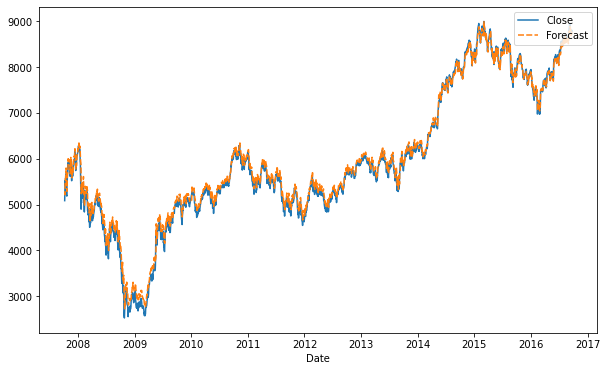

In [22]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=train_graph)
ax.legend (loc="upper right")

In [23]:
import math
trainScore = math.sqrt(mean_squared_error(train_graph['Close'], train_graph['Forecast']))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 120.97 RMSE


In [25]:
testX=[]
for i in range(n_past, len(test) - n_future +1):
    testX.append(test[i - n_past:i, 0:train.shape[1]])
testX=np.array(testX)

In [27]:
print('trainX shape == {}.'.format(testX.shape))

trainX shape == (1117, 14, 4).


In [28]:
testX_re=testX.reshape((testX.shape[0],1,testX.shape[1],testX.shape[2]))
testX_re.shape

(1117, 1, 14, 4)

In [29]:
testing_data_prediction= model.predict(testX_re) 
forecast_copies_2 = np.repeat(testing_data_prediction, test.shape[1], axis=-1)
predicted_test = scaler.inverse_transform(forecast_copies_2)[:,0]
predicted_test

array([ 8553.906,  8526.711,  8567.773, ..., 15328.068, 15616.871,
       15757.816], dtype=float32)

In [30]:
Test_data=Data[train_size+n_past:len(stock_prices_scaled)]
Test_data['Date']=pd.to_datetime(Test_data['Date'])
testing_forecast = pd.DataFrame( {'Date':Test_data['Date'],'Close':Test_data['Close'],'Forecast':predicted_test})
test_graph=testing_forecast.set_index('Date')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


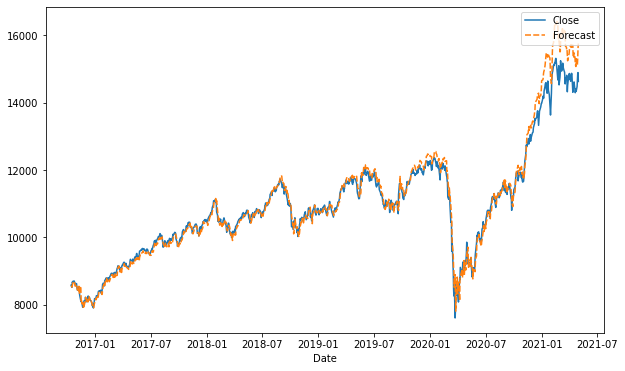

In [31]:
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data=test_graph)
ax.legend (loc="upper right")

In [32]:
import math
testScore = math.sqrt(mean_squared_error(test_graph['Close'], test_graph['Forecast']))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 302.03 RMSE
